## Import Libraries 

In [1]:
import pandas as pd
import numpy as np
import requests 
import datetime
import time
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud

#importing the sklearns
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from nltk.stem import WordNetLemmatizer

stopwords = nltk.corpus.stopwords.words('english')
pd.set_option('display.max_colwidth', 100)

In [145]:
df_apple_submission = pd.read_csv('../data/apple_submission.csv', low_memory=False)
df_apple_submission.head()
#load apple submission csv

,Unnamed: 0,author,permalink,selftext,subreddit,title
0,0,lanabi,/r/apple/comments/qlwqu4/goodnotes_5_has_its_first_ever_discount_possibly/,NaN,apple,GoodNotes 5 has its first ever discount possibly in an effort to win over disgruntled Notability...
1,1,spearson0,/r/apple/comments/qlwmpd/future_ipad_pro_and_macbook_pro_models_rumored_to/,NaN,apple,Future iPad Pro and MacBook Pro Models Rumored to Feature Ultra-Bright Double-Stack OLED Displays
2,2,walktall,/r/apple/comments/qlw32x/apple_in_talks_with_samsung_display_to_apply_oled/,NaN,apple,Apple in talks with Samsung Display to apply OLED to MacBook
3,3,walktall,/r/apple/comments/qlw2j5/apple_once_again_refers_to_unreleased_homeos_in/,NaN,apple,Apple Once Again Refers to Unreleased 'homeOS' in Job Listing
4,4,Alternative_Tip5572,/r/apple/comments/qlu52i/allah_khushian_kab_deta_hai_molana_tariq_jameel/,NaN,apple,Allah Khushian Kab Deta Hai – Molana Tariq Jameel Latest Bayan - Naat


In [132]:
df_samsung_submission = pd.read_csv('../data/samsung_submission.csv', low_memory=False)
df_samsung_submission.head()
#load samsung submission csv

,Unnamed: 0,author,permalink,selftext,subreddit,title
0,0,shaselai,/r/samsung/comments/qlwvqg/is_the_s22_ultra_leakedspeculated_specs_causing/,I am currently still trying to figure out if I want to return my 13 promax because of UI annoyan...,samsung,Is the S22 Ultra leaked/speculated specs causing excitement or lukewarm?
1,1,Maddy555,/r/samsung/comments/qlwnjd/in_new_update_good_lock_oho_good_guardians_are/,NaN,samsung,"In new update, Good Lock, OHO+ &amp; Good Guardians are ready for One UI 4"
2,2,mercenary_58,/r/samsung/comments/qlutq8/is_the_base_s21_exynos_256gb_a_great_phone_for/,i ordered an base s21 exynos and it’s coming next week. i’m wondering if this is a great phone t...,samsung,is the BASE S21 EXYNOS 256gb a great phone for long term?
3,3,prathneo4,/r/samsung/comments/qlukmz/should_i_wait_for_s22_or_get_s21/,I am getting S21+ at really good value. ₹42K to be specific (including exchange)\n\nShould you g...,samsung,Should i wait for S22 or get S21+?
4,4,EmeraldForce64,/r/samsung/comments/qlsgyb/what_would_happen_if_i_flashed_the_wrong_firmware/,What would happen,samsung,What would happen if i flashed the wrong firmware on a phone? Lets say i flash a S21 ROM on an S...


# Functions 

In [4]:
def clean_text(text): #clean text for nlp 

    #remove all numbers
    text = re.sub(r'\d+', '',text)
    # remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    text = ''.join(c for c in text if c <= '\uFFFF')
    #remove emails
    text = re.sub(r'\S*\*\s?', '', text)
    # Remove words with 2 or fewer letters
    text = re.sub(r'\b\w{1,2}\b', '', text)
    # remove whitespace (including new line characters)
    text = re.sub(r'\s\s+', ' ', text)   
    
    # \W matches any non-word character (equivalent to [^a-zA-Z0-9_]). This does not include spaces i.e. \s
    text = "".join([word.lower() for word in text if word not in string.punctuation])

    # Add a + just in case there are 2 or more spaces between certain words
    tokens = re.split('\W+', text)
    
    # apply lemmatizing and stopwords exclusion within the same step
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word.lower()) for word in tokens if word not in stopwords]

    #remove any trailing space found after lemmatizing
    for x in text :
        for i in x:
            if i == '':
                x.remove(i)
        
    return ' '.join(text)

In [5]:
def clean_hyperlinks(text):     
    # Remove hyperlinks
    text = re.sub(r"((http|ftp|https):\/\/)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", text)
    return text

In [6]:
def confusion_matx(model,y_test, pred,score):
    cm= confusion_matrix(y_test, pred)
    modified_cm = []
    for index,value in enumerate(cm):
        if index == 0:
            modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])]) #first array will be 0
        if index == 1: 
            modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   #second array will be 1
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 20},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['versicolor', 'viginica'],
            yticklabels = ['versicolor', 'viginica'],
            );

    plt.ylabel('Actual label', fontsize = 17);
    plt.xlabel('Predicted label', fontsize = 17);
    plt.title('Accuracy Score for {}: {:.3f}'.format(model,score), size = 17);
    plt.tick_params(labelsize= 15)

In [7]:
def roc_curve(model,x_test_cvec,y_test):
    plt.figure(figsize=(15,15))
    plot_roc_curve(model, X_test_cvec, y_test)
    plt.plot([0, 1], [0, 1],
             label='baseline', linestyle='--')
    fig = plt.gcf()
    fig.set_size_inches(8,7)
    plt.legend();

In [131]:
def get_top_phrase(word1, n=None):
    vec = CountVectorizer(ngram_range=(2, 3), stop_words=stopwords).fit(word1)
    bag_of_words = vec.transform(word1)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, x]) for word, x in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [8]:
add_stop_words = ['did', 'doe', 'don', 'doesn', 'getting', 'going', 'got', 'ha', 'isn', 'wa',
                  'ive','youre','become','became','would','still','also','could','see','get','well','one','much','even','sure',
                 'use', 'know', 'want','take','like','way','say','need','come','make','anyone','want', "i've", "i'm" , 'made',
                  'samsung', 'apple']
stopwords.extend(add_stop_words)
stopwords
#adding additonal words to stop words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

## Data Cleaning Part 1

- Part 1 is to check and remove necessary null values and combine apple and samsung to one dataframe

*Cleaning samsung csv*

In [133]:
df_samsung_submission['selftext'].isna().value_counts()

False    7421
True     2573
Name: selftext, dtype: int64

In [134]:
df_samsung_submission.dropna(subset=['selftext'], inplace=True)
#drop null values for selftext

In [135]:
df_samsung_submission['selftext'].isna().value_counts()

False    7421
Name: selftext, dtype: int64

*Removing AutoModerator post*

In [136]:
(df_samsung_submission['author'] == 'AutoModerator').value_counts()

False    7294
True      127
Name: author, dtype: int64

In [137]:
df_samsung_submission[df_samsung_submission['author'] == 'AutoModerator'] ['selftext']

6       Welcome to the Daily Support thread for [r/Samsung](https://www.reddit.com/r/samsung/). You can ...
27      Welcome to the Daily Support thread for [r/Samsung](https://www.reddit.com/r/samsung/). You can ...
54      Welcome to the Daily Support thread for [r/Samsung](https://www.reddit.com/r/samsung/). You can ...
79      Welcome to the Daily Support thread for [r/Samsung](https://www.reddit.com/r/samsung/). You can ...
104     Welcome to the Daily Support thread for [r/Samsung](https://www.reddit.com/r/samsung/). You can ...
                                                       ...                                                 
2693    # Join our discord for awesome tech support, great chat, and future giveaways! [https://discord....
2732    Welcome to the Daily (Tech) Support thread for [r/Samsung](https://www.reddit.com/r/samsung/). Y...
4411    #  If you have ANY questions, please join our official discord and we'll be happy to answer them...
4414    # If you have ANY qu

This shows that automoderator author have many duplicated,similar irrelevant post for the model. Not to be included further

In [138]:
df_samsung_submission = df_samsung_submission[df_samsung_submission['author'] != 'AutoModerator']
#only keep post that are not automoderator author

In [139]:
(df_samsung_submission['author'] == 'AutoModerator').value_counts()

False    7294
Name: author, dtype: int64

*Removing [removed] post*

In [140]:
(df_samsung_submission['selftext'] == '[removed]').value_counts()

False    7294
Name: selftext, dtype: int64

No [removed] post found

*Removing posts with [deleted]*

In [141]:
(df_samsung_submission['selftext'] == '[deleted]').value_counts()

False    7191
True      103
Name: selftext, dtype: int64

Small percentage of 103 [deleted] post found. Will not include further as not useful to the model

In [142]:
df_samsung_submission = df_samsung_submission[df_samsung_submission['selftext'] != '[deleted]']

In [143]:
(df_samsung_submission['selftext'] == '[deleted]').value_counts()

False    7191
Name: selftext, dtype: int64

In [144]:
df_samsung_submission= df_samsung_submission[['title', 'selftext','subreddit']]
df_samsung_submission

,title,selftext,subreddit
0,Is the S22 Ultra leaked/speculated specs causing excitement or lukewarm?,I am currently still trying to figure out if I want to return my 13 promax because of UI annoyan...,samsung
2,is the BASE S21 EXYNOS 256gb a great phone for long term?,i ordered an base s21 exynos and it’s coming next week. i’m wondering if this is a great phone t...,samsung
3,Should i wait for S22 or get S21+?,I am getting S21+ at really good value. ₹42K to be specific (including exchange)\n\nShould you g...,samsung
4,What would happen if i flashed the wrong firmware on a phone? Lets say i flash a S21 ROM on an S...,What would happen,samsung
5,Should I go for smarttags or consider an alternative?,I keep losing my keys all around the house and I'm wondering if I should go for the Smarttags or...,samsung
...,...,...,...
9988,S21 ultra front camera vertical lines?,Anybody having a problem getting multicolored vertical lines on the front camera of the s21 ult...,samsung
9989,One ui 3.0 on note 10+ bug?,"I got one ui 3.0 on my note 10+ yesterday, and a couple hours later the touchscreen only works s...",samsung
9990,Does the S21 Ultra have 'live focus' on normal photo camera? I can't see it in the options,Does the S21 Ultra have 'live focus' on normal photo camera? I can't see it in the options,samsung
9991,Samsung tablet S5e trouble with streaming services not working - cache? reset? How to fix?,I have a year old Samsung Tablet S5e - love it. But suddenly some of the streaming services don'...,samsung


After completing of  part 1 data cleaning for samsung subreddit, it now have 7192  rows.

***Repeat above steps for apple submission csv***

In [146]:
df_apple_submission.shape

(39770, 6)

In [147]:
df_apple_submission['selftext'].isna().value_counts()
#check for null values in selftext

True     30933
False     8837
Name: selftext, dtype: int64

In [148]:
df_apple_submission.dropna(subset=['selftext'], inplace=True)
#drop null values for selftext

In [149]:
df_apple_submission['selftext'].isna().value_counts()

False    8837
Name: selftext, dtype: int64

*Removing AutoModerator post*

In [150]:
(df_apple_submission['author'] == 'AutoModerator').value_counts()

False    8010
True      827
Name: author, dtype: int64

Shows that there are a number of post that are submitted by moderator author. Not to include them further

In [151]:
df_apple_submission = df_apple_submission[df_apple_submission['author'] != 'AutoModerator']
#only keep post that are not automoderator author

In [152]:
(df_apple_submission['author'] == 'AutoModerator').value_counts()

False    8010
Name: author, dtype: int64

*Removing [removed] post*

In [153]:
(df_apple_submission['selftext'] == '[removed]').value_counts()
#no removed post

False    8010
Name: selftext, dtype: int64

No [removed] post found. No action taken

*Removing posts with [deleted]*

In [154]:
(df_apple_submission['selftext'] == '[deleted]').value_counts()

False    7328
True      682
Name: selftext, dtype: int64

682 selftext found to be deleted. To not included further as it is not useful for the model

In [155]:
df_apple_submission = df_apple_submission[df_apple_submission['selftext'] != '[deleted]']

In [156]:
(df_apple_submission['selftext'] == '[deleted]').value_counts()

False    7328
Name: selftext, dtype: int64

In [157]:
df_apple_submission= df_apple_submission[['title', 'selftext','subreddit']]
df_apple_submission

,title,selftext,subreddit
11,Thanks apple,Thanks to your anti consumer move to take the charger out of the box you have screwed your custo...,apple
94,Got a notification “your Apple ID….” But clicked away before I could read it. What could it have...,I did recently get the iPhone 13 pro so maybe something about setting something up? But everythi...,apple
113,Airpods Pro Sales?,Thinking of getting Airpod Pros soon. Which site and deal do you all expect should I wait for at...,apple
114,Still Li-ion batteries?,Just saw the JRE video of iPhone 13 pro max and it showed that Apple is still using Li-ion batte...,apple
115,So Texans cannot add their COVID19 Vaccines to their wallet right?,"Just so I understand this right, I was super excited to update toward IOS 15.1 for the digital v...",apple
...,...,...,...
39745,Can ipad pro 2018 model play movies from a micro sd?,"With an adapter, can the ipad pro 2018 model play mkv/avi videos from a micro sd with an adapter?",apple
39746,Can someone help me I was installing iOS 13 and it gave me an error.,It says \n“Error installing update\nUpdate could not be installed”\nThen it gives me two options...,apple
39755,Is there a difference between the 11'' and 12.9'' iPad Pro?,"I want to buy an iPad Pro but I can’t decide which one I should buy. Of course, the 11'' is chea...",apple
39756,PSA: Airpods not connecting,"Hey all, I just want to share my experience trying to fix my airpods and explain how I saved mys...",apple


After completing of  part 1 data cleaning for apple subreddit, it now have 7328 rows.

*Combine samsung and apple submission into one df*

In [158]:
df_submission = pd.concat([df_apple_submission, df_samsung_submission], ignore_index=True)

In [159]:
#concatenating of title and the post text
df_submission['title_txt'] = df_submission['title'] + " " + df_submission['selftext']

In [160]:
df_submission

,title,selftext,subreddit,title_txt
0,Thanks apple,Thanks to your anti consumer move to take the charger out of the box you have screwed your custo...,apple,Thanks apple Thanks to your anti consumer move to take the charger out of the box you have screw...
1,Got a notification “your Apple ID….” But clicked away before I could read it. What could it have...,I did recently get the iPhone 13 pro so maybe something about setting something up? But everythi...,apple,Got a notification “your Apple ID….” But clicked away before I could read it. What could it have...
2,Airpods Pro Sales?,Thinking of getting Airpod Pros soon. Which site and deal do you all expect should I wait for at...,apple,Airpods Pro Sales? Thinking of getting Airpod Pros soon. Which site and deal do you all expect s...
3,Still Li-ion batteries?,Just saw the JRE video of iPhone 13 pro max and it showed that Apple is still using Li-ion batte...,apple,Still Li-ion batteries? Just saw the JRE video of iPhone 13 pro max and it showed that Apple is ...
4,So Texans cannot add their COVID19 Vaccines to their wallet right?,"Just so I understand this right, I was super excited to update toward IOS 15.1 for the digital v...",apple,So Texans cannot add their COVID19 Vaccines to their wallet right? Just so I understand this rig...
...,...,...,...,...
14514,S21 ultra front camera vertical lines?,Anybody having a problem getting multicolored vertical lines on the front camera of the s21 ult...,samsung,S21 ultra front camera vertical lines? Anybody having a problem getting multicolored vertical l...
14515,One ui 3.0 on note 10+ bug?,"I got one ui 3.0 on my note 10+ yesterday, and a couple hours later the touchscreen only works s...",samsung,"One ui 3.0 on note 10+ bug? I got one ui 3.0 on my note 10+ yesterday, and a couple hours later ..."
14516,Does the S21 Ultra have 'live focus' on normal photo camera? I can't see it in the options,Does the S21 Ultra have 'live focus' on normal photo camera? I can't see it in the options,samsung,Does the S21 Ultra have 'live focus' on normal photo camera? I can't see it in the options Does ...
14517,Samsung tablet S5e trouble with streaming services not working - cache? reset? How to fix?,I have a year old Samsung Tablet S5e - love it. But suddenly some of the streaming services don'...,samsung,Samsung tablet S5e trouble with streaming services not working - cache? reset? How to fix? I hav...


In [161]:
df_submission.to_csv('../data/submission.csv', index=False)
#save combine in csv

# EDA

In [162]:
df_submission['length_title'] = df_submission['title'].apply(len)
#get the length of title

In [163]:
df_submission['length_selftext']  =  df_submission['selftext'].apply(len)
#get the length of selftext

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


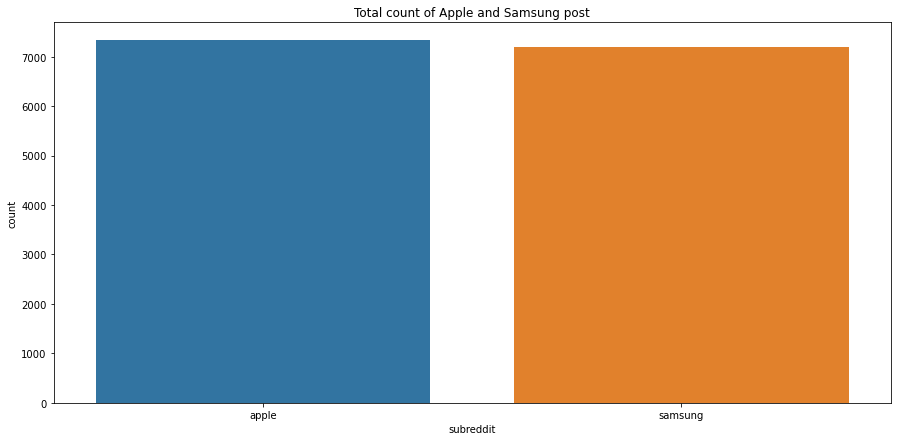

In [164]:
plt.figure(figsize=(15, 7))
sns.countplot(df_submission['subreddit'],label = 'Count')
plt.title('Total count of Apple and Samsung post');

Observation: Apple have slightly more post count than samsung after data filtering

In [165]:
length_submission_title = df_submission [['length_title']]
length_submission_selftext =  df_submission [['length_selftext']]

In [166]:
length_submission_title .describe()

,length_title
count,14519.000000
mean,50.720504
std,35.610541
min,1.000000
25%,28.000000
50%,42.000000
75%,62.000000
max,302.000000


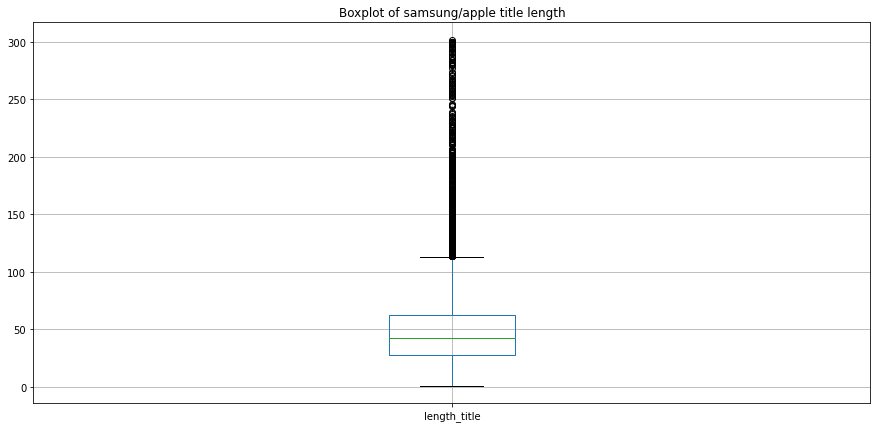

In [167]:
plt.figure(figsize=(15, 7))
length_submission_title .boxplot()
plt.title('Boxplot of samsung/apple title length');

Observation: The range of title length is between 1 to 302 with its median at 42 character and Q3 at 62 char. This shows definitely there will be a lot of out outliers. However, they will still be included as it may be useful for the model. As having less than 2 characters will not be useful f, this will not be included in the model moving forward.

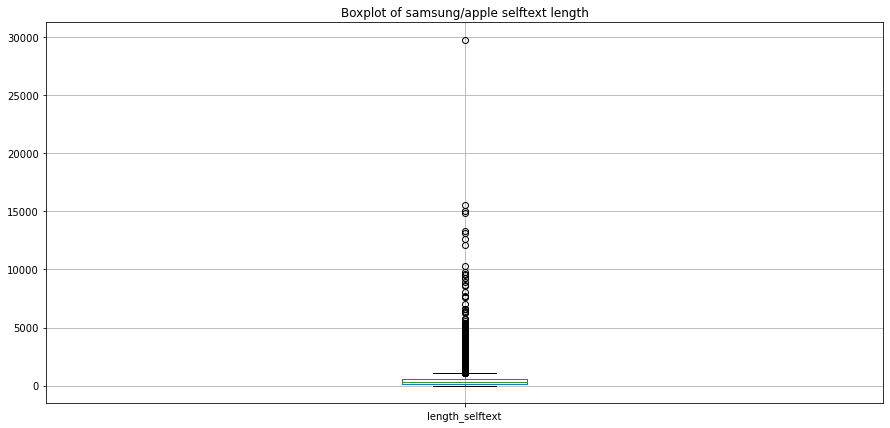

In [168]:
plt.figure(figsize=(15, 7))
length_submission_selftext.boxplot()
plt.title('Boxplot of samsung/apple selftext length');

In [169]:
length_submission_selftext.describe()

,length_selftext
count,14519.000000
mean,465.810937
std,697.325197
min,1.000000
25%,168.000000
50%,300.000000
75%,533.000000
max,29770.000000


Observation: The range of selftext length is between 1 to 29770 with its median at 300 character and Q3 at 533 char thus having a huge amount of outliers as well . However, they will still be included as it may be useful for the model. As having less than 2 characters will not be useful , this will not be included in the model moving forward.

In [170]:
df_submission['target'] = df_submission['subreddit'].map({'apple':1, 'samsung': 0})
df_submission.drop('subreddit', axis=1, inplace=True)
#mapping 1 to apple, 0 to samsung

In [171]:
samsung = df_submission[df_submission['target']==0]
apple = df_submission[df_submission['target']==1]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


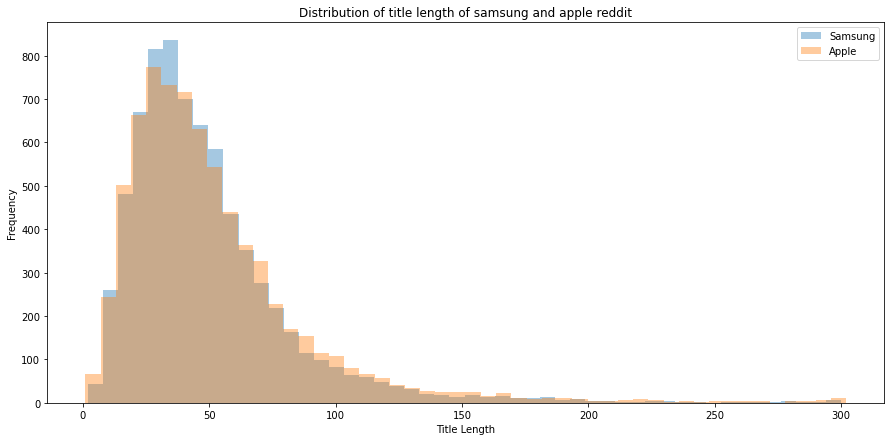

In [172]:
plt.figure(figsize=(15,7))
sns.distplot(samsung[samsung['target'] == 0]['length_title'], kde=False, label='Samsung')
sns.distplot(apple[apple['target'] == 1]['length_title'], kde=False, label='Apple')
plt.title('Distribution of title length of samsung and apple reddit')
plt.ylabel('Frequency')
plt.xlabel('Title Length')
plt.legend();

Observation: Title of length is rightly skewed for both Apple and Samsung reddit with Samsung having higher frequency for its mode at rougly 40 characters

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


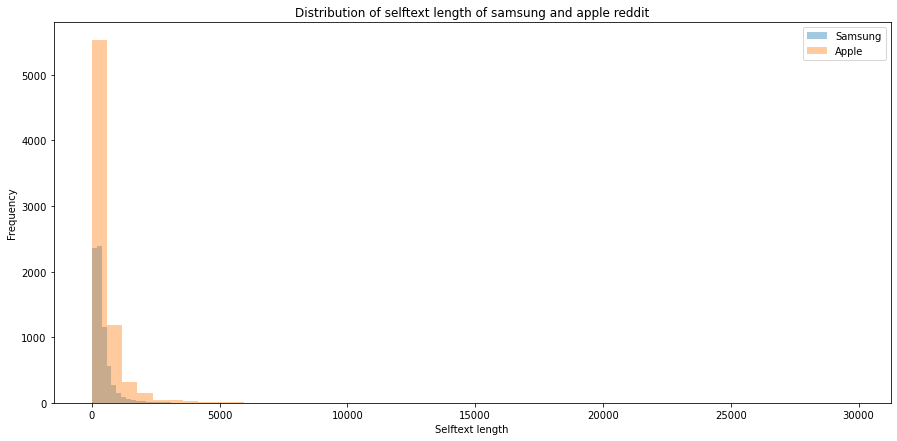

In [173]:
plt.figure(figsize=(15,7))
sns.distplot(samsung[samsung['target'] == 0]['length_selftext'], kde=False, label='Samsung')
sns.distplot(apple[apple['target'] == 1]['length_selftext'], kde=False, label='Apple')
plt.title('Distribution of selftext length of samsung and apple reddit')
plt.ylabel('Frequency')
plt.xlabel('Selftext length')
plt.legend();

Observation: Length of selftext is rightly skewed for both Apple and Samsung reddit. Apple have a much frequency despite having same mode with samsung between 0-5 char.

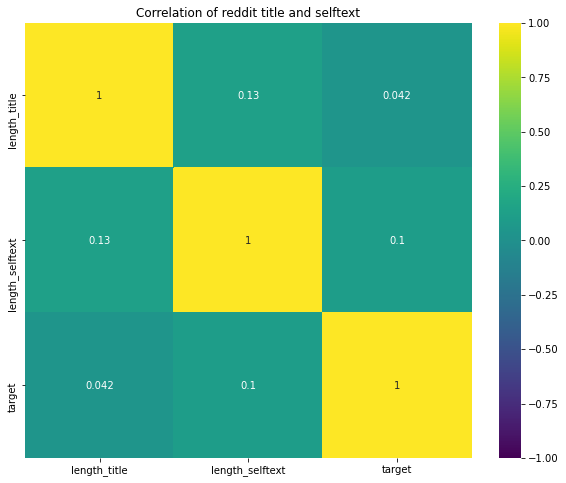

In [174]:
plt.figure(figsize=(10,8))
plt.title('Correlation of reddit title and selftext')
sns.heatmap(df_submission.corr(),
           annot=True,
           cmap='viridis',
           vmin=-1);

Observation : This diagram shows that besides correlation with themselves, they are not highly correlated.

# Data Cleaning Part 2 and EDA
- Part 2 is to clean title_txt column from hyperlinks and get the most used words and phrases without including the stop words before NLP process

In [175]:
df_submission['title_txt'] = df_submission['title_txt'].apply(clean_hyperlinks)
#to remove hyperlinks 

In [176]:
samsung_sentences = samsung['title_txt'].tolist()
samsung_sentences_as_one_string = " ".join(samsung_sentences).lower() #join all in one sentence for samsung

In [177]:
apple_sentences = apple['title_txt'].tolist()
apple_sentences_as_one_string = " ".join(apple_sentences).lower() #join all in one sentence for   apple

In [182]:
#init wordcloud instance.To view words that appear frequently without stopwords
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_font_size=80, max_words=10)

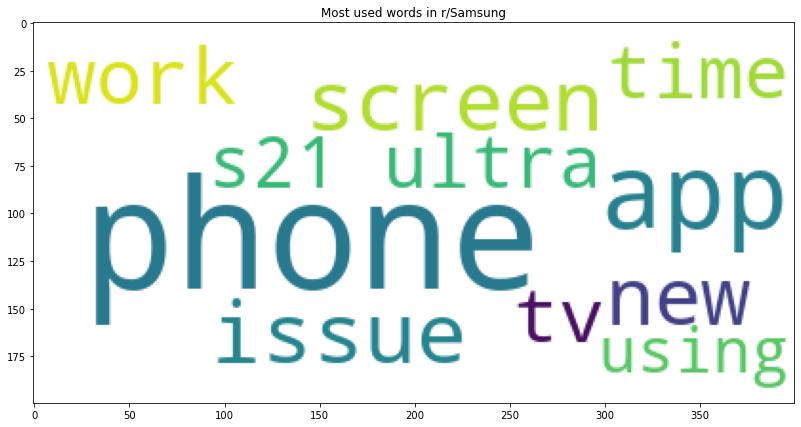

In [183]:
plt.figure(figsize=(15,7))
plt.title('Most used words in r/Samsung')
plt.imshow(wordcloud.generate(samsung_sentences_as_one_string)); 
#view the most used words in samsung

Observation: Above shows the 10 most used in r/Samsung without the stopwords. Most dominant words found for r/Samsung are phone, s21 ultra and app

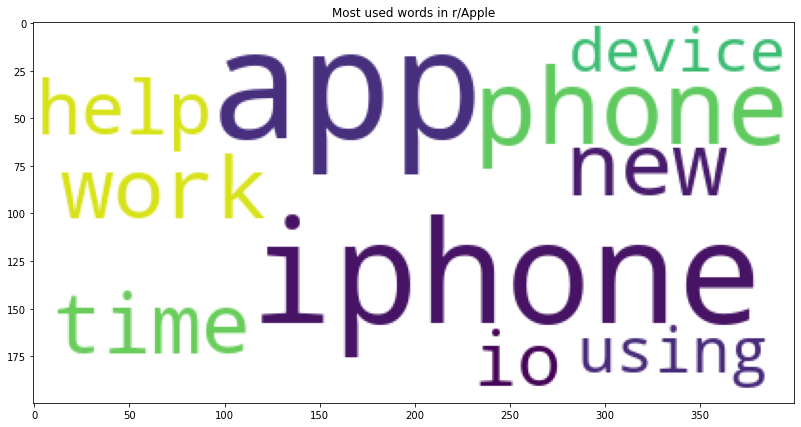

In [184]:
plt.figure(figsize=(15,7))
plt.title('Most used words in r/Apple')
plt.imshow(wordcloud.generate(apple_sentences_as_one_string )); 
#view the most used words in samsung

Observation: Above shows the 10 most used in r/Apple without the stopwords.It have few similar words with samsung such as app and phone and a different dominant word which is iphone

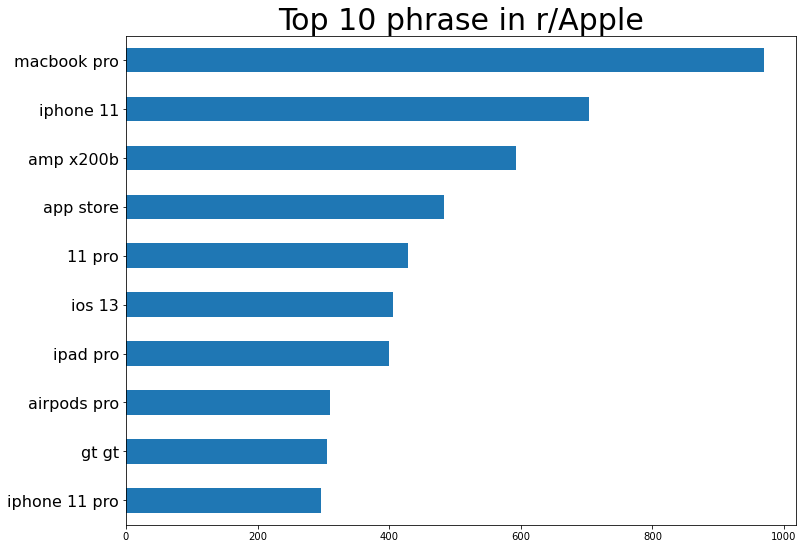

In [185]:
#common phrase for Apple
common_words_mh = get_top_phrase(df_submission[df_submission['target']==1]['title_txt'], 10)

phrase_df = pd.DataFrame(common_words_mh, columns = ['text' , 'count'])

plt.figure(figsize=(12, 9));
phrase_df.groupby('text').sum()['count'].sort_values(ascending=True).plot(kind='barh');
plt.ylabel('');
plt.title('Top 10 phrase in r/Apple', fontdict={'fontsize': 30});
#set large enough font size for ytick labels 
plt.gca().tick_params(axis='y', labelsize=16);

Obsevations: Above shows the top 10 bigram for apple with stopwords not included. Diagram shows the top phrases
are mostly just their recent products with macbook pro being the top

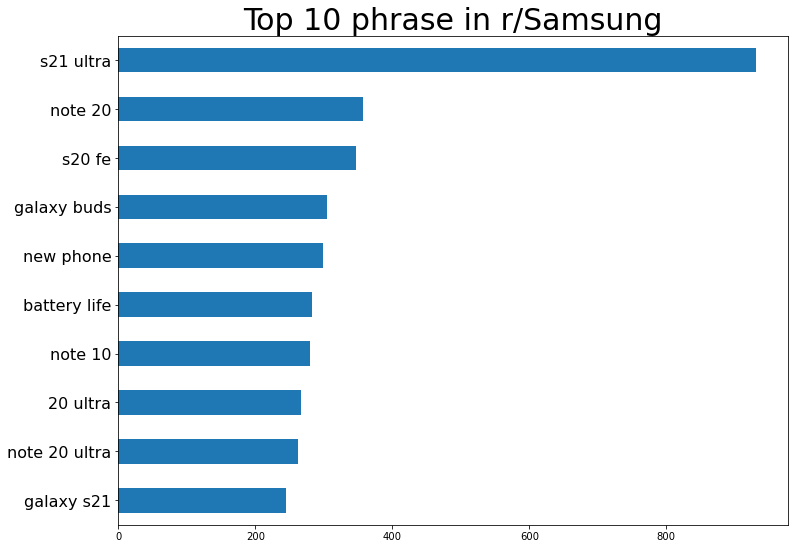

In [186]:
#common phrase for Samsung
common_words_mh = get_top_phrase(df_submission[df_submission['target']==0]['title_txt'], 10)

phrase_df = pd.DataFrame(common_words_mh, columns = ['text' , 'count'])

plt.figure(figsize=(12, 9));
phrase_df.groupby('text').sum()['count'].sort_values(ascending=True).plot(kind='barh');
plt.ylabel('');
plt.title('Top 10 phrase in r/Samsung', fontdict={'fontsize': 30});
#set large enough font size for ytick labels 
plt.gca().tick_params(axis='y', labelsize=16);

Observations:Above shows the top 10 bigram phrase for Samsung reddit without stopwords. Similarly to Apple, it consist mostly of their recent product name with s21 ultra as the top

# NLP Pre Processing

In [187]:
df_submission

,title,selftext,title_txt,length_title,length_selftext,target
0,Thanks apple,Thanks to your anti consumer move to take the charger out of the box you have screwed your custo...,Thanks apple Thanks to your anti consumer move to take the charger out of the box you have screw...,12,516,1
1,Got a notification “your Apple ID….” But clicked away before I could read it. What could it have...,I did recently get the iPhone 13 pro so maybe something about setting something up? But everythi...,Got a notification “your Apple ID….” But clicked away before I could read it. What could it have...,102,515,1
2,Airpods Pro Sales?,Thinking of getting Airpod Pros soon. Which site and deal do you all expect should I wait for at...,Airpods Pro Sales? Thinking of getting Airpod Pros soon. Which site and deal do you all expect s...,18,132,1
3,Still Li-ion batteries?,Just saw the JRE video of iPhone 13 pro max and it showed that Apple is still using Li-ion batte...,Still Li-ion batteries? Just saw the JRE video of iPhone 13 pro max and it showed that Apple is ...,23,171,1
4,So Texans cannot add their COVID19 Vaccines to their wallet right?,"Just so I understand this right, I was super excited to update toward IOS 15.1 for the digital v...",So Texans cannot add their COVID19 Vaccines to their wallet right? Just so I understand this rig...,66,435,1
...,...,...,...,...,...,...
14514,S21 ultra front camera vertical lines?,Anybody having a problem getting multicolored vertical lines on the front camera of the s21 ult...,S21 ultra front camera vertical lines? Anybody having a problem getting multicolored vertical l...,38,134,0
14515,One ui 3.0 on note 10+ bug?,"I got one ui 3.0 on my note 10+ yesterday, and a couple hours later the touchscreen only works s...","One ui 3.0 on note 10+ bug? I got one ui 3.0 on my note 10+ yesterday, and a couple hours later ...",27,361,0
14516,Does the S21 Ultra have 'live focus' on normal photo camera? I can't see it in the options,Does the S21 Ultra have 'live focus' on normal photo camera? I can't see it in the options,Does the S21 Ultra have 'live focus' on normal photo camera? I can't see it in the options Does ...,90,90,0
14517,Samsung tablet S5e trouble with streaming services not working - cache? reset? How to fix?,I have a year old Samsung Tablet S5e - love it. But suddenly some of the streaming services don'...,Samsung tablet S5e trouble with streaming services not working - cache? reset? How to fix? I hav...,90,525,0


In [188]:
df_submission.drop(df_submission[(df_submission['selftext'] == df_submission['title'])].index, inplace =True)
#dropping rows where selftext is the same as title

In [189]:
df_submission = df_submission[['title_txt','target']]
df_submission

,title_txt,target
0,Thanks apple Thanks to your anti consumer move to take the charger out of the box you have screw...,1
1,Got a notification “your Apple ID….” But clicked away before I could read it. What could it have...,1
2,Airpods Pro Sales? Thinking of getting Airpod Pros soon. Which site and deal do you all expect s...,1
3,Still Li-ion batteries? Just saw the JRE video of iPhone 13 pro max and it showed that Apple is ...,1
4,So Texans cannot add their COVID19 Vaccines to their wallet right? Just so I understand this rig...,1
...,...,...
14513,New update broke fingerprint reader? (S10) Ever since the update my finger print reader has been...,0
14514,S21 ultra front camera vertical lines? Anybody having a problem getting multicolored vertical l...,0
14515,"One ui 3.0 on note 10+ bug? I got one ui 3.0 on my note 10+ yesterday, and a couple hours later ...",0
14517,Samsung tablet S5e trouble with streaming services not working - cache? reset? How to fix? I hav...,0


In [190]:
df_submission['txt_lem'] = df_submission['title_txt'].map(clean_text)
# clean the title_txt from hyperlinks

<ipython-input-190-2c19c968ad04>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submission['txt_lem'] = df_submission['title_txt'].map(clean_text)


In [191]:
df_submission

,title_txt,target,txt_lem
0,Thanks apple Thanks to your anti consumer move to take the charger out of the box you have screw...,1,thanks thanks anti consumer move charger box screwed customer enabled every company thing tellin...
1,Got a notification “your Apple ID….” But clicked away before I could read it. What could it have...,1,notification clicked away read recently iphone pro maybe something setting something everything ...
2,Airpods Pro Sales? Thinking of getting Airpod Pros soon. Which site and deal do you all expect s...,1,airpods pro sale thinking airpod pro soon site deal expect wait time year thanks
3,Still Li-ion batteries? Just saw the JRE video of iPhone 13 pro max and it showed that Apple is ...,1,ion battery saw jre video iphone pro max showed using ion battery whole industry shifted towards...
4,So Texans cannot add their COVID19 Vaccines to their wallet right? Just so I understand this rig...,1,texan cannot add covid vaccine wallet right understand right super excited update toward io dig...
...,...,...,...
14513,New update broke fingerprint reader? (S10) Ever since the update my finger print reader has been...,0,new update broke fingerprint reader ever since update finger print reader acting mostly recogniz...
14514,S21 ultra front camera vertical lines? Anybody having a problem getting multicolored vertical l...,0,ultra front camera vertical line anybody problem multicolored vertical line front camera ultra ...
14515,"One ui 3.0 on note 10+ bug? I got one ui 3.0 on my note 10+ yesterday, and a couple hours later ...",0,note bug note yesterday couple hour later touchscreen work sometimes tap time tap register pen w...
14517,Samsung tablet S5e trouble with streaming services not working - cache? reset? How to fix? I hav...,0,tablet trouble streaming service working cache reset fix year old tablet love suddenly streaming...


In [196]:
df_submission['target'].value_counts(normalize=True)
#normalize the samsung and apple post

1    0.505114
0    0.494886
Name: target, dtype: float64

Although not totally the same , the numbers don't seem too much off difference so can assume that it is normalize.

# Model Prep

In [197]:
X = df_submission['txt_lem']
y = df_submission['target']

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=200,  stratify=y)
#using stratify to preserves the same proportions of examples in each class

In [199]:
y_train.value_counts()

1    5481
0    5371
Name: target, dtype: int64

In [200]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwords)),
    ('lr', LogisticRegression(solver='liblinear'))
])
#Create a pipile to do a gridsearch to find best value for countvectorizer in logistic Regression

In [201]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500, 4000,4500],
    'cvec__min_df': [1, 3, 5],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2) ]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)


In [202]:
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8902504648752673


{'cvec__max_df': 0.9,
 'cvec__max_features': 4500,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 2)}

In [203]:
gs.score(X_test, y_test)

0.8960751796572692

## Vectorizing with the best params

In [204]:
cvec = CountVectorizer(max_df=0.9, max_features=4500, min_df=5, ngram_range=(1,2), stop_words=stopwords)
#replacing with best parameter found in gridsearch

In [205]:
X_train_cvec = cvec.fit_transform(X_train, y_train).todense()

In [206]:
X_test_cvec = cvec.transform(X_test).todense()

In [207]:
X_train_cvec.shape

(10852, 4500)

# Logistic Regression Model

In [208]:

logreg = LogisticRegression(solver='liblinear')
log_reg_params = {
    'C': np.linspace(1, 10)
}
#finding the best c parameter

In [209]:
gs_logreg = GridSearchCV(logreg, param_grid=log_reg_params, cv=3)
gs_logreg.fit(X_train_cvec, y_train)
print(gs_logreg.best_score_)
gs_logreg.best_params_

0.8901583838861784


{'C': 1.0}

In [210]:
gs_logreg.score(X_train_cvec, y_train)

0.9811094729082197

In [211]:
gs_logreg.score(X_test_cvec, y_test)

0.8960751796572692


## Re-initialising Logistic Regression Model with best parameters

In [212]:
logreg = LogisticRegression(C=1.0, solver='liblinear') #using the best value in C ingridsearch
logreg.fit(X_train_cvec, y_train)

LogisticRegression(solver='liblinear')

In [213]:
print('Logistic Regression Model Train Score:', logreg.score(X_train_cvec, y_train))
print('Logistic Regression Model Test Score:', logreg.score(X_test_cvec, y_test))

Logistic Regression Model Train Score: 0.9811094729082197
Logistic Regression Model Test Score: 0.8960751796572692


Observation: There seems to be a loss of 0.08 between train and test scores

In [214]:
logreg_score = logreg.score(X_test_cvec, y_test)

## Top features

In [215]:
coefs=logreg.coef_[0]

In [216]:
word_coef1 = pd.Series(coefs, index=cvec.get_feature_names()).sort_values(ascending=False)

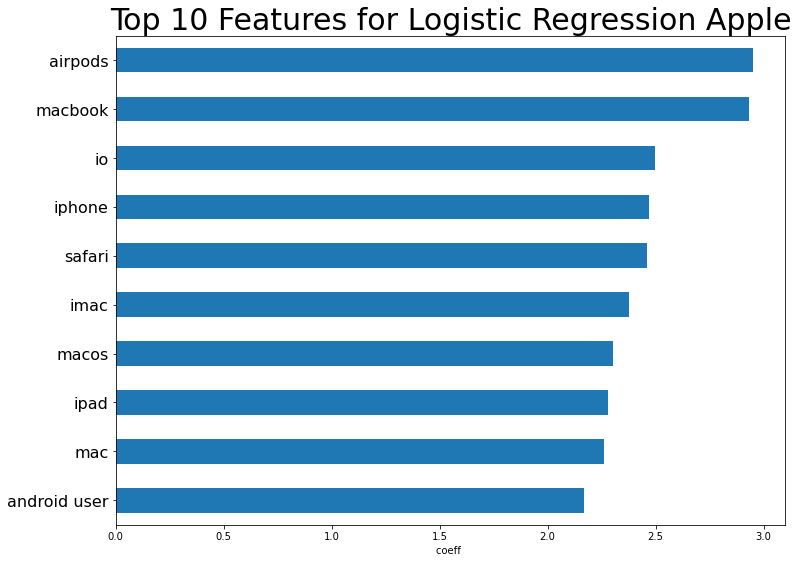

In [217]:
plt.figure(figsize=(12, 9));
word_coef1.head(10).sort_values(ascending=True).plot(kind='barh');
plt.xlabel('coeff ');
plt.title('Top 10 Features for Logistic Regression Apple', fontdict={'fontsize': 30});
#set large enough font size for ytick labels 
plt.gca().tick_params(axis='y', labelsize=16);

Observation: Above diagram shows the top features of apple which are mostly the products of apple in logistic regression with airpod at the top.

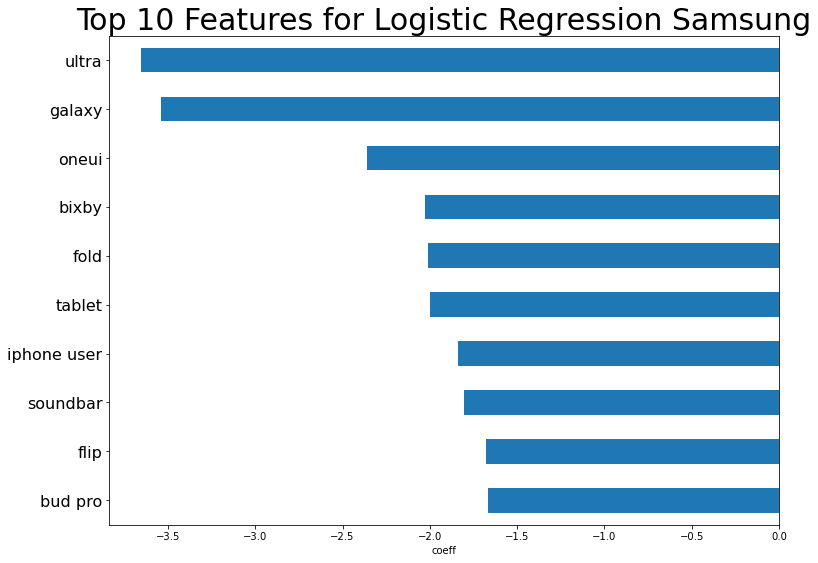

In [218]:
plt.figure(figsize=(12, 9));
word_coef1.tail(10).sort_values(ascending=False).plot(kind='barh');
plt.xlabel('coeff');
plt.title('Top 10 Features for Logistic Regression Samsung', fontdict={'fontsize': 30});
#set large enough font size for ytick labels 
plt.gca().tick_params(axis='y', labelsize=16);

Observation: Above diagram shows the top features of samsung which are mostly the products of samsung in logistic regression with macbook at the top, similar to before nlp was processed. However, one interesting found is that iphone user is phone in a competitor reddit.

In [219]:
#construct list of probabilities
pred_proba_logreg = [i[1] for i in logreg.predict_proba(X_test_cvec)]

In [220]:
print("ROC AUC Score: ", roc_auc_score(y_test, pred_proba_logreg))

ROC AUC Score:  0.9611484297641896


<Figure size 1080x1080 with 0 Axes>

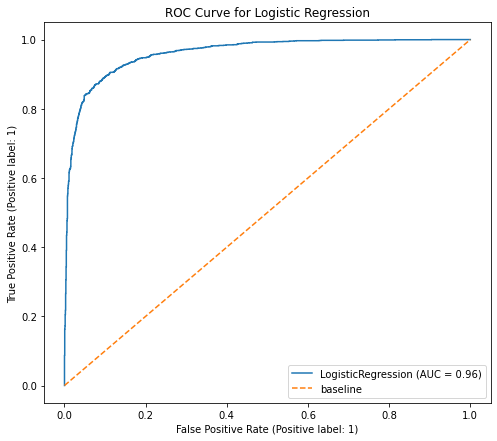

In [221]:
roc_curve(logreg, X_test_cvec, y_test)
plt.title('ROC Curve for Logistic Regression');


The ROC Curve above shows that the two classes are quite distinct with the area under the curve does not lie on the baseline. This means that the classification is very distinct between the two classes.

In [222]:
#Put the actual values and predicted probabilities in a dataframe
pred_logreg_df = pd.DataFrame({'actual': y_test, 'pred': pred_proba_logreg})

In [223]:
pred_logreg_df['predict'] = logreg.predict(X_test_cvec)

In [224]:
#put all misclassifications into a dataframe
pred_false_logreg = pred_logreg_df[pred_logreg_df['actual'] != pred_logreg_df['predict']]

In [225]:
pred_false_logreg.head()

,actual,pred,predict
11568,0,0.936582,1
638,1,0.440834,0
12742,0,0.725716,1
9780,0,0.718040,1
11086,0,0.504267,1


In [226]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_logreg_df['predict']).ravel()

In [227]:
print("True Negatives: %s" % tn)
print("True Positives: %s" % tp)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)

True Negatives: 1604
True Positives: 1638
False Positives: 186
False Negatives: 190


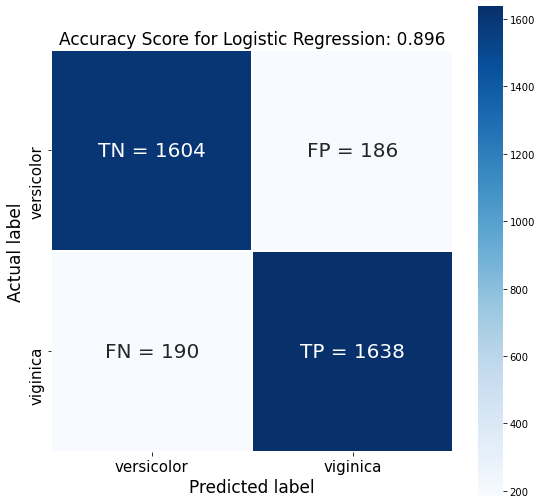

In [228]:
confusion_matx("Logistic Regression",y_test, pred_logreg_df['predict'],logreg_score)

This model does fairly well on classifying the posts into either subreddits. Most of the classifications are correct while leaving only some misclassification at 359, accounting for 0.11 of the total.

# Naive-Bayes Model

In [229]:
nb = MultinomialNB()

In [230]:
nb.fit(X_train_cvec, y_train)

MultinomialNB()

In [231]:
print('Naive-Bayes Model Train Score:', nb.score(X_train_cvec, y_train))
print('Naive-Bayes Model Test Score:', nb.score(X_test_cvec, y_test))

Naive-Bayes Model Train Score: 0.9033357906376704
Naive-Bayes Model Test Score: 0.8891652846876728


Observations : Test and train scores are does not have much loss as compared to regression despite having lower scores 

In [232]:
score_nb=nb.score(X_test_cvec, y_test)

In [233]:
#positive class prob
pos_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
#negative class prob
neg_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()


## Top Features

In [234]:
#get top features Samsung
p_top_features = np.take(cvec.get_feature_names(), neg_class_prob_sorted)
#get top features for Apple
mh_top_features = np.take(cvec.get_feature_names(), pos_class_prob_sorted)

In [235]:
#joining them together
nb_top_features = [p_top_features]
nb_top_features.append(mh_top_features)

In [236]:
#Get top features of both subreddits
nb_top_features_df = pd.DataFrame(data=nb_top_features).T

In [237]:
#show top 20 features for each subreddit
print("Top 20 Features for Naive-Bayes Model")
nb_top_features_df.columns = ['Samsung', 'Apple']
nb_top_features_df.head(20)

Top 20 Features for Naive-Bayes Model


,Samsung,Apple
0,price match,macrumors
1,knox,macbook ipad
2,note lite,retina display
3,smart thing,final cut
4,exynos version,mac pro
5,qled,mac mini
6,qled series,mac iphone
7,qna,mac book
8,smart view,work ipad
9,inch class,find iphone


Observation: Above shows the top most probable features by subreddit.  The top probably words are the lemmatize words "price match" and "macrumors" belonging to r/Samsung and r/Apple respectively. Comparing to logistic regression, it has more descriptive words than just product names.

It also shows the product or features talk most by users that was newly launched and updated by Apple or Samsung such as macbook pro and knox.

In [238]:
pred_nb = nb.predict(X_test_cvec)

In [239]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_nb).ravel()

In [240]:
print("True Positives: %s" % tp)
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)


True Positives: 1606
True Negatives: 1611
False Positives: 179
False Negatives: 222


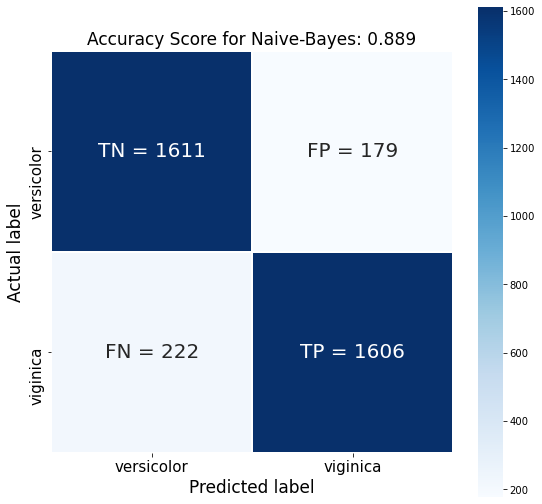

In [241]:
confusion_matx("Naive-Bayes",y_test, pred_nb,score_nb)

This model does fairly well on classifying the posts into either subreddits. Most of the classifications are correct while leaving only some misclassification at 385, accounting for 0.12 of the total.

In [242]:
#construct list of probabilities
pred_proba_nb = [i[1] for i in nb.predict_proba(X_test_cvec)]

In [243]:
print("ROC AUC Score for Naive Bayes: ", roc_auc_score(y_test, pred_proba_nb))

ROC AUC Score for Naive Bayes:  0.9543309841937336


Text(0.5, 1.0, 'ROC Curve for Naive Bayes')

<Figure size 1080x1080 with 0 Axes>

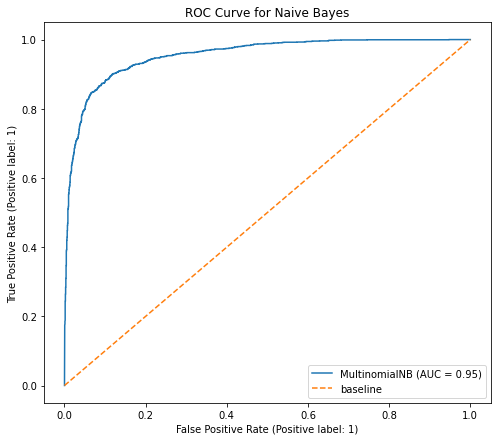

In [244]:
roc_curve(nb, X_test_cvec, y_test)
plt.title('ROC Curve for Naive Bayes')

The ROC Curve shown above shows that the two classes are quite distinct with the area under the curve that does not lie on the baseline. This means that the classification is still very distinct between the two classes despite having lower scores than logistic regression.

In [245]:

#Put the actual values and predicted probabilities in a dataframe
pred_nb_df = pd.DataFrame({'actual': y_test, 'pred': pred_proba_nb})

In [246]:
pred_nb_df['predict'] = pred_nb

In [247]:
pred_nb_false_df = pred_nb_df[pred_nb_df['actual'] != pred_nb_df['predict']]

In [248]:
pred_nb_false_df.shape

(401, 3)

# Random Forest

In [249]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [250]:
rf_params = {'n_estimators': [25, 100, 200],
             'max_depth': [None, 1, 3, 5, 7], 
             'max_features': [3, 5, 7]
    
}

In [251]:
gs_rf = GridSearchCV(rf, param_grid=rf_params, cv=3, verbose=1, n_jobs=-1)
gs_rf.fit(X_train_cvec, y_train)
print('Best score:', gs_rf.best_score_)
gs_rf.best_params_

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Best score: 0.8979906170618355


{'max_depth': None, 'max_features': 7, 'n_estimators': 200}

In [252]:
rf_best = RandomForestClassifier(max_depth=None, max_features=7, n_estimators=200)

In [253]:
rf_best.fit(X_train_cvec, y_train)

RandomForestClassifier(max_features=7, n_estimators=200)

In [254]:
print("Random Forest Model training score: ", rf_best.score(X_train_cvec, y_train))
print("Random Forest Model test score:", rf_best.score(X_test_cvec, y_test))

Random Forest Model training score:  0.999447106524143
Random Forest Model test score: 0.9126589275843007


Observation: There is a loss of 0.09 between train and test score .

In [255]:
word_imp_ = pd.DataFrame({'word': cvec.get_feature_names() , 'feature_importance': rf_best.feature_importances_})

In [256]:
word_coef3 = pd.Series(rf_best.feature_importances_, index=cvec.get_feature_names()).sort_values(ascending=False)

In [257]:
word_imp_.sort_values(by='feature_importance', ascending=False).head(10)

,word,feature_importance
1959,iphone,0.025391
1518,galaxy,0.021006
2269,macbook,0.012833
1938,io,0.011173
4116,ultra,0.010636
2745,phone,0.010045
2980,pro,0.008742
96,airpods,0.008162
1949,ipad,0.008011
2262,mac,0.006467


Observation: Above shows the top 10 coeffs in using Random Forest Model. However, the word does not classify well which word belongs to apple or samsung reddit 

In [258]:
pred_proba_rf = rf_best.predict_proba(X_test_cvec)

#extracting out the n_class probabilities for calc ROC AUC Score
rf_pred_sample_proba = []
for i in pred_proba_rf:
    rf_pred_sample_proba.append(i[1])

In [259]:
print("ROC AUC Score: ", roc_auc_score(y_test, rf_pred_sample_proba))

ROC AUC Score:  0.9666321834162561


<Figure size 1080x1080 with 0 Axes>

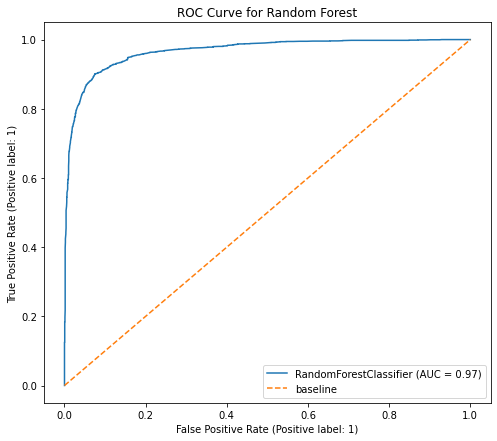

In [260]:
roc_curve(rf_best, X_test_cvec, y_test)
plt.title('ROC Curve for Random Forest');


The ROC Curve shown above shows that the two classes are quite distinct with the area under the curve that does not lie on the baseline. This means that the classification is very distinct between the two classes.

# Conclusion

|Model| Training Test    | Test Score |  ROC AUC Score |
| ----------- | ----------- | ----------- |   ----------- |
| Logisic Regression | 0.98    |       0.90     |   0.96 | 
|Naive-Bayes   | 0.90     |   0.89       |   0.96 |
|Random Forest|  1.0 |  0.91  |   0.97 |

### Best Model 
The best model in terms of test score will be the Logistic Random Forest with  ROC AUC score of 0.97 which is pretty close to the other models. In general, their misclassification class also does not differ much. 

However, the chosen and winner model will be Naive-Bayes model. Looking at the scores, despite having the lowest score, the test and train model scores only have a loss of 0.01 with still a goof ROC  score of 0.96 which shows it does not overfit and generalize well. It clearly specify the top features by the the subreddit and recognise the bigrams in each class that are rank higher in each category.

Despite Random forest having the best scores, it overfits with 0.09 loss and the words does not classify well which word belongs to which reddit. 



### Recommendations

Using naive bayes model can help to indicate what are the current trends and topic are posted by users at a specific time. However, it is not sufficient to indicate the sentiment of the post where it is positive or negative.

Additionally, extracting their sentiment will be good to know the post is based determined by the attitude or the emotion of the writer due to them being rivals, there will be tendency of users posting negatively about the other brand . 